# Chapter 10 
# Intro to Artificial Neural Networks with Keras

In [13]:
# Setup
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

from tensorflow import keras
assert keras.__version__ >= "2.2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Perceptrons

Let's use the Perceptron class from Scikit-Learn to implement a single-TLU network for the iris dataset.

In [14]:
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)] # petal length, petal width
y = (iris.target == 0).astype(np.int)

perceptron_classifier = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
perceptron_classifier.fit(X, y)

y_predictions = perceptron_classifier.predict([[2, 0.5]])

In [15]:
y_predictions

array([1])

Saving figure perceptron_iris_plot


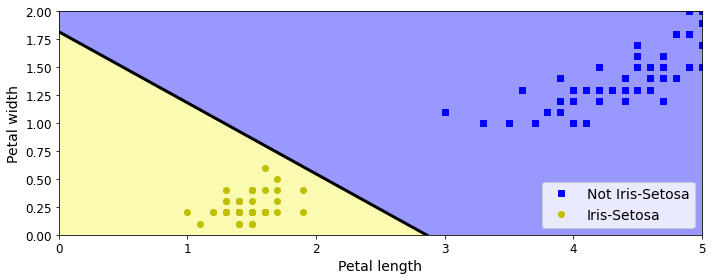

In [16]:
a = -perceptron_classifier.coef_[0][0] / perceptron_classifier.coef_[0][1]
b = -perceptron_classifier.intercept_ / perceptron_classifier.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = perceptron_classifier.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

# Activation Functions

See pg. 291

In [17]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

Saving figure activation_functions_plot


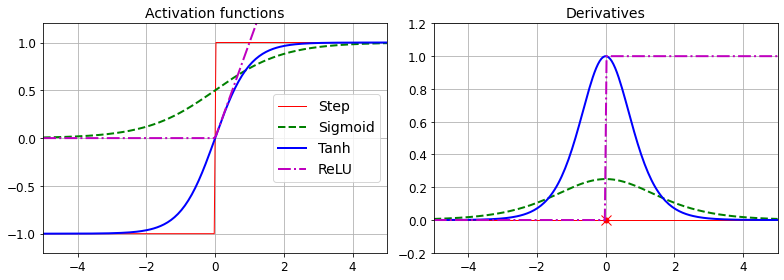

In [18]:

z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

# Build an Image Classifier

Using the Sequential API

## Data Setup & Basic Exploration

In [19]:
# In this example we will be using the Fashion MNIST Dataset

# Use Keras to load the dataset
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [20]:
X_train_full.shape

(60000, 28, 28)

In [21]:
# ^ The training set contains 60,000 grayscale images, each 28x28 pixels

In [22]:
X_train_full.dtype

dtype('uint8')

In [23]:
# ^ Each pixel intensity is represented as a byte (0 to 255)

In [24]:
# Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

X_validation, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_validation, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255 

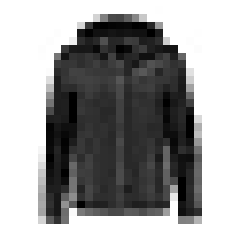

In [25]:
# Let's take a look at one instance of the dataset
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [26]:
#  The labels are the class IDs (represented as uint8), from 0 to 9:

# Here are the corresponding class names:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [27]:
# Above we see a 'Coat'
class_names[y_train[0]]

'Coat'

In [28]:
X_validation.shape

(5000, 28, 28)

In [29]:
X_test.shape

(10000, 28, 28)

Saving figure fashion_mnist_plot


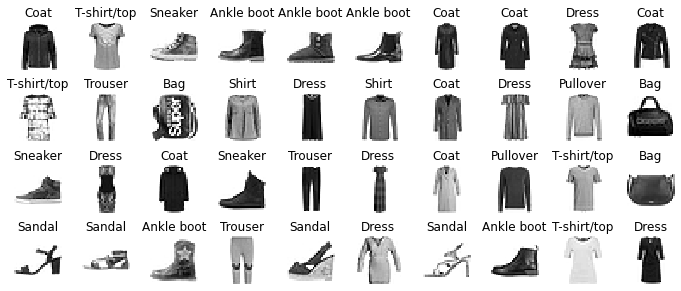

In [30]:
# Let's take a look at a sample of the images in the dataset:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

## Create the model using the Sequential API

Now let's build the neural network.

This is a classification MLP with two hidden layers:

In [31]:
# Reset the run
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [32]:
#model = keras.models.Sequential()
#model.add(keras.layers.Flatten(input_shape=[28, 28]))
#model.add(keras.layers.Dense(300, activation="relu"))
#model.add(keras.layers.Dense(100, activation="relu"))
#model.add(keras.layers.Dense(10, activation="softmax"))

# Same as:

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [33]:

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [34]:
# ^ Notice that Dense layers often have a lot of parameters. For example, the first hidden layer has 784 x 300 connection weights, plus 300 bias terms, which adds up to 235,500 parameters.

# This gives the model quite a lot of flexibility to fit the training data, but it also means that the model runs the risk of overfitting.

In [35]:
# Now we can also inspect the model closer and rename layers
model.layers

In [36]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [37]:
model.get_layer('dense') is hidden1

True

In [38]:
# All of the parameters of a layer can be accessed using its get_weights() and set_weights() methods.
# For a Dense layer, this includes both the connection weights and the bias terms.

weights, biases = hidden1.get_weights()

In [39]:
weights # Notice these are randomly intialized (Good, we need to break any symmetry)

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [40]:
weights.shape

(784, 300)

In [ ]:
# The shape of the weights matrix depends on the number of inputs. This is why it is recommended to specify the input_shape when creating the first layer in a sequential model.

In [41]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [42]:
biases.shape

(300,)

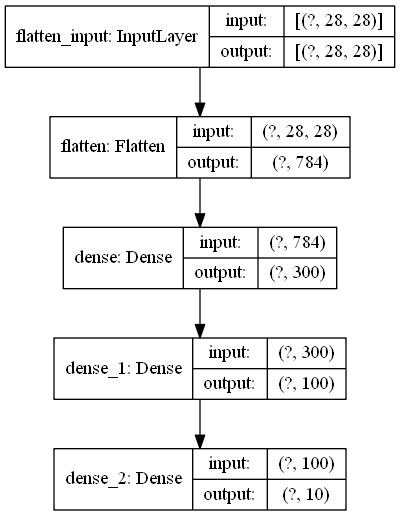

In [43]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

## Compile the Model

In [44]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="sgd",
    metrics=["accuracy"]
)

## Training the model

In [45]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_validation, y_validation))

Epoch 1/30
1719/1719 [==============================] - 1s 680us/step - loss: 0.7237 - accuracy: 0.7643 - val_loss: 0.5213 - val_accuracy: 0.8226
Epoch 2/30
1719/1719 [==============================] - 1s 624us/step - loss: 0.4842 - accuracy: 0.8316 - val_loss: 0.4351 - val_accuracy: 0.8514
Epoch 3/30
1719/1719 [==============================] - 1s 625us/step - loss: 0.4391 - accuracy: 0.8455 - val_loss: 0.5269 - val_accuracy: 0.8008
Epoch 4/30
1719/1719 [==============================] - 1s 652us/step - loss: 0.4123 - accuracy: 0.8567 - val_loss: 0.3915 - val_accuracy: 0.8648
Epoch 5/30
1719/1719 [==============================] - 1s 606us/step - loss: 0.3939 - accuracy: 0.8620 - val_loss: 0.3746 - val_accuracy: 0.8694
Epoch 6/30
1719/1719 [==============================] - 1s 625us/step - loss: 0.3750 - accuracy: 0.8675 - val_loss: 0.3710 - val_accuracy: 0.8734
Epoch 7/30
1719/1719 [==============================] - 1s 612us/step - loss: 0.3630 - accuracy: 0.8713 - val_loss: 0.3617 -

In [46]:
# Notice that the accuracy: 0.9198 is close to the val_accuracy: 0.8932
# This shows that there does not seem to be much overfitting going on.

## Evaluate the Model

In [47]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [48]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [49]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [50]:
# Dictionary containing the loss and extra metrics it measure at the end of each epoch on the training set and on the validation set.
# history.history

# The keys
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Saving figure keras_learning_curves_plot


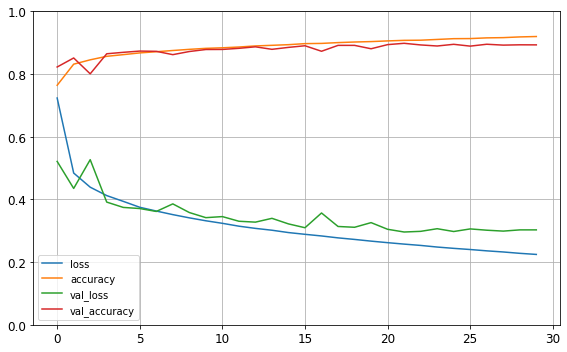

In [51]:
# We can use this Dictionary to create a pandas DataFrame to show the learning curves.
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

## Evaluate the model on the test set

In [52]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 389us/step - loss: 0.3366 - accuracy: 0.8826


[0.3366280198097229, 0.8826000094413757]

## Use the model to make new predictions

In [53]:
X_new = X_test[:3]
y_probability = model.predict(X_new)
y_probability.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.02, 0.  , 0.96],
       [0.  , 0.  , 0.98, 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [54]:
# ^ As you can see, for each instance the model estimates one probability per class.

In [55]:
# We can use the predict_classes() to only see the classes with the highest estimated probability.

# y_predictions = model.predict_classes(X_new) # This is deprecated.
y_predictions = np.argmax(model.predict(X_new), axis=-1)
#y_predictions = (model.predict(X_new) > 0.5).astype("int32")
y_predictions

array([9, 2, 1], dtype=int64)

In [56]:
np.array(class_names)[y_predictions]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [57]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

In [58]:
np.array(class_names)[y_new]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

Saving figure fashion_mnist_images_plot


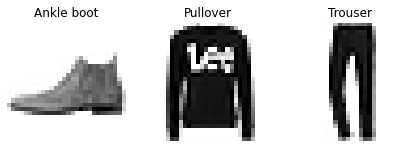

In [59]:
# We can see that the model got all three predictions correct.

plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

# Building a Regression MLP

Using the Sequential API

## Load the Data

Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2):

In [60]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing_data = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing_data.data, housing_data.target, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

In [61]:
np.random.seed(42)
tf.random.set_seed(42)

In [62]:
# Create the Model
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]), # Shape of an instance
    keras.layers.Dense(1),
])

# Since the data is quite noisy, we jut use a single hidden layer with fewer neurons than before to avoid overfitting.

In [63]:
# Compile the Model
learning_rate = 1e-3

model.compile(
    loss="mean_squared_error", 
    optimizer=keras.optimizers.SGD(lr=learning_rate)
)

In [64]:
# Train the Model
history = model.fit(
    X_train, 
    y_train, 
    epochs=20, 
    validation_data=(X_validation, y_validation)
)

Epoch 1/20
363/363 [==============================] - 0s 536us/step - loss: 1.6419 - val_loss: 0.8560
Epoch 2/20
363/363 [==============================] - 0s 396us/step - loss: 0.7047 - val_loss: 0.6531
Epoch 3/20
363/363 [==============================] - 0s 387us/step - loss: 0.6345 - val_loss: 0.6099
Epoch 4/20
363/363 [==============================] - 0s 376us/step - loss: 0.5977 - val_loss: 0.5658
Epoch 5/20
363/363 [==============================] - 0s 385us/step - loss: 0.5706 - val_loss: 0.5355
Epoch 6/20
363/363 [==============================] - 0s 385us/step - loss: 0.5472 - val_loss: 0.5173
Epoch 7/20
363/363 [==============================] - 0s 398us/step - loss: 0.5288 - val_loss: 0.5081
Epoch 8/20
363/363 [==============================] - 0s 387us/step - loss: 0.5130 - val_loss: 0.4799
Epoch 9/20
363/363 [==============================] - 0s 387us/step - loss: 0.4992 - val_loss: 0.4690
Epoch 10/20
363/363 [==============================] - 0s 396us/step - loss: 0.487

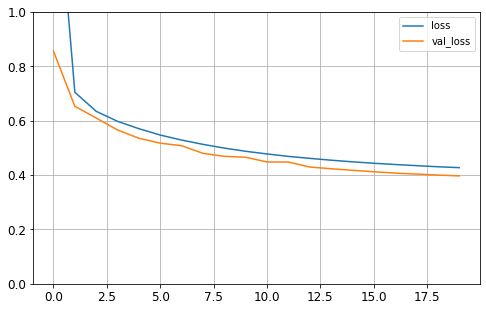

In [65]:
# Evaluate the Model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [66]:
# Evaluate the Model
mse_test = model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 259us/step - loss: 0.4212


In [67]:
# Use the Model to make predictions
X_new = X_test[:3] # Pretend these are new instances
y_predictions = model.predict(X_new)
y_predictions

array([[0.3885664],
       [1.6792021],
       [3.1022797]], dtype=float32)

# Building Complex Models

Using the Functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see paper) connects all or part of the inputs directly to the output layer.

Let's tackle the California Housing Prices problem again using this approach.

In [68]:
# Reset the run
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [69]:
# Create the model
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.Concatenate()([input_, hidden2])
output = keras.layers.Dense(1)(concat)

model = keras.Model(inputs=[input_], outputs=[output])

# See the diagram on pg. 309

In [70]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           930         dense[0][0]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_1[0][0]         

In [71]:
# Compile the model
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))

In [72]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_validation, y_validation))

Epoch 1/20
363/363 [==============================] - 0s 580us/step - loss: 1.2611 - val_loss: 3.3940
Epoch 2/20
363/363 [==============================] - 0s 418us/step - loss: 0.6580 - val_loss: 0.9360
Epoch 3/20
363/363 [==============================] - 0s 418us/step - loss: 0.5878 - val_loss: 0.5649
Epoch 4/20
363/363 [==============================] - 0s 434us/step - loss: 0.5582 - val_loss: 0.5712
Epoch 5/20
363/363 [==============================] - 0s 418us/step - loss: 0.5347 - val_loss: 0.5045
Epoch 6/20
363/363 [==============================] - 0s 415us/step - loss: 0.5158 - val_loss: 0.4831
Epoch 7/20
363/363 [==============================] - 0s 420us/step - loss: 0.5002 - val_loss: 0.4639
Epoch 8/20
363/363 [==============================] - 0s 415us/step - loss: 0.4876 - val_loss: 0.4638
Epoch 9/20
363/363 [==============================] - 0s 420us/step - loss: 0.4760 - val_loss: 0.4421
Epoch 10/20
363/363 [==============================] - 0s 434us/step - loss: 0.465

In [73]:
# Evaluate the Model
mse_test = model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 265us/step - loss: 0.4032


In [74]:
# Use the model to make new predictions
y_predictions = model.predict(X_new)
y_predictions

array([[0.4701073],
       [1.8735044],
       [3.379823 ]], dtype=float32)

### Handling Multiple Inputs

What if we want to send a subset of the features through the wide path and a different subset (possibly overlapping) through the deep path?

In [75]:
# Reset the run
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [76]:
# Create the model
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)

model = keras.Model(inputs=[input_A, input_B], outputs=[output])

In [77]:
# Compile the model
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [78]:
# Setup the data for the inputs
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:] # Notice the overlap
X_validation_A, X_validation_B = X_validation[:, :5], X_validation[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

In [79]:
# Train the model
history = model.fit(
    (X_train_A, X_train_B),
    y_train,
    epochs=20,
    validation_data=((X_validation_A, X_validation_B), y_validation)
)

Epoch 1/20
363/363 [==============================] - 0s 610us/step - loss: 1.8145 - val_loss: 0.8072
Epoch 2/20
363/363 [==============================] - 0s 429us/step - loss: 0.6771 - val_loss: 0.6658
Epoch 3/20
363/363 [==============================] - 0s 431us/step - loss: 0.5979 - val_loss: 0.5687
Epoch 4/20
363/363 [==============================] - 0s 431us/step - loss: 0.5584 - val_loss: 0.5296
Epoch 5/20
363/363 [==============================] - 0s 434us/step - loss: 0.5334 - val_loss: 0.4993
Epoch 6/20
363/363 [==============================] - 0s 431us/step - loss: 0.5120 - val_loss: 0.4811
Epoch 7/20
363/363 [==============================] - 0s 420us/step - loss: 0.4970 - val_loss: 0.4696
Epoch 8/20
363/363 [==============================] - 0s 440us/step - loss: 0.4843 - val_loss: 0.4496
Epoch 9/20
363/363 [==============================] - 0s 429us/step - loss: 0.4730 - val_loss: 0.4404
Epoch 10/20
363/363 [==============================] - 0s 407us/step - loss: 0.464

In [80]:
# Evaluate the model
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
mse_test

162/162 [==============================] - 0s 283us/step - loss: 0.4219


0.42188265919685364

In [81]:
y_pred = model.predict((X_new_A, X_new_B))
y_pred

array([[0.30591208],
       [1.9540672 ],
       [3.442611  ]], dtype=float32)

In [82]:
# Notice that this model actually performed really poorly (43%) but it is just a demonstration of the architecture.

### Adding an auxiliary output for regularization

See the architecture diagram on pg. 312

In [83]:
# Reset the run
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [84]:
# Create the model
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [85]:
# Compile the model
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

In [86]:
# Train the model
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_validation_A, X_validation_B], [y_validation, y_validation]))

Epoch 1/20
363/363 [==============================] - 0s 756us/step - loss: 2.1365 - main_output_loss: 1.9196 - aux_output_loss: 4.0890 - val_loss: 1.6233 - val_main_output_loss: 0.8468 - val_aux_output_loss: 8.6117
Epoch 2/20
363/363 [==============================] - 0s 486us/step - loss: 0.8905 - main_output_loss: 0.6969 - aux_output_loss: 2.6326 - val_loss: 1.5163 - val_main_output_loss: 0.6836 - val_aux_output_loss: 9.0109
Epoch 3/20
363/363 [==============================] - 0s 478us/step - loss: 0.7429 - main_output_loss: 0.6088 - aux_output_loss: 1.9499 - val_loss: 1.4639 - val_main_output_loss: 0.6229 - val_aux_output_loss: 9.0326
Epoch 4/20
363/363 [==============================] - 0s 478us/step - loss: 0.6771 - main_output_loss: 0.5691 - aux_output_loss: 1.6485 - val_loss: 1.3388 - val_main_output_loss: 0.5481 - val_aux_output_loss: 8.4552
Epoch 5/20
363/363 [==============================] - 0s 489us/step - loss: 0.6381 - main_output_loss: 0.5434 - aux_output_loss: 1.4911 

In [87]:
# Evaluate the model
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], 
    [y_test, y_test]
)

total_loss, main_loss, aux_loss

162/162 [==============================] - 0s 339us/step - loss: 0.4668 - main_output_loss: 0.4178 - aux_output_loss: 0.9082


(0.4668305218219757, 0.4177945852279663, 0.9081541299819946)

In [88]:
# Use the model to make predictions
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])
y_pred_main, y_pred_aux

(array([[0.26762432],
        [1.9807628 ],
        [3.3396287 ]], dtype=float32),
 array([[0.9593649],
        [1.9240992],
        [2.5152814]], dtype=float32))

# Using the Subclassing API to build Dynamic Models

In [103]:
# Reset the run
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [104]:
# Let's create the same architecture we had above using the Subclassing API (see pg. 312 diagram)

class WideAndDeepModel(keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs) # handles standard args (e.g. name)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)

    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

In [105]:
# Create the model
model = WideAndDeepModel(30, activation="relu")

In [106]:
# Compile the model
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

In [107]:
# Train the model
history = model.fit(
    (X_train_A, X_train_B), 
    (y_train, y_train), 
    epochs=10,
    validation_data=((X_validation_A, X_validation_B), (y_validation, y_validation))
)

Epoch 1/10
363/363 [==============================] - 0s 758us/step - loss: 2.1365 - output_1_loss: 1.9196 - output_2_loss: 4.0890 - val_loss: 1.6233 - val_output_1_loss: 0.8468 - val_output_2_loss: 8.6117
Epoch 2/10
363/363 [==============================] - 0s 481us/step - loss: 0.8905 - output_1_loss: 0.6969 - output_2_loss: 2.6326 - val_loss: 1.5163 - val_output_1_loss: 0.6836 - val_output_2_loss: 9.0109
Epoch 3/10
363/363 [==============================] - 0s 478us/step - loss: 0.7429 - output_1_loss: 0.6088 - output_2_loss: 1.9499 - val_loss: 1.4639 - val_output_1_loss: 0.6229 - val_output_2_loss: 9.0326
Epoch 4/10
363/363 [==============================] - 0s 492us/step - loss: 0.6771 - output_1_loss: 0.5691 - output_2_loss: 1.6485 - val_loss: 1.3388 - val_output_1_loss: 0.5481 - val_output_2_loss: 8.4552
Epoch 5/10
363/363 [==============================] - 0s 481us/step - loss: 0.6381 - output_1_loss: 0.5434 - output_2_loss: 1.4911 - val_loss: 1.2177 - val_output_1_loss: 0.519

In [108]:
# Evaluate the model
total_loss, main_loss, aux_loss = model.evaluate(
    (X_test_A, X_test_B),
    (y_test, y_test)
)

total_loss, main_loss, aux_loss

162/162 [==============================] - 0s 332us/step - loss: 0.5279 - output_1_loss: 0.4605 - output_2_loss: 1.1352


(0.5279498100280762, 0.46047818660736084, 1.135195016860962)

In [109]:
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))
y_pred_main, y_pred_aux

(array([[0.3014863],
        [1.6784242],
        [3.0203466]], dtype=float32),
 array([[1.030725 ],
        [1.6647578],
        [2.2852385]], dtype=float32))

# Saving and Restoring a Model

In [110]:
# Reset the run
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [111]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [113]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_validation, y_validation))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 0s 569us/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 0s 412us/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 0s 404us/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 0s 407us/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 0s 409us/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 0s 401us/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 0s 407us/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 0s 404us/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 0s 393us/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 265us/step - loss: 0.438

### Save the Model

In [114]:
# Save the Model

# Note that you first need to compile and fit the model

model.save("my_keras_model.h5")

### Load the Model

In [115]:
model = keras.models.load_model("my_keras_model.h5")

In [116]:
# use the loaded model to make predictions:
model.predict(X_new)

array([[0.5400236],
       [1.6505969],
       [3.0098243]], dtype=float32)

While this was easy and works for the Sequential API and Functional API, it doesn't work for the Subclassing API models.

The best we can do is save the weights to save and restore the model parameters, but everything else will need to be done ourselves

In [117]:
model.save_weights("my_keras_weights.ckpt")

In [118]:
model.load_weights("my_keras_weights.ckpt")

# Using Callbacks during Training

In [119]:
# Reset the run
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [120]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [121]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [122]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)

In [124]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_validation, y_validation),
                    callbacks=[checkpoint_cb])

Epoch 1/10
363/363 [==============================] - 0s 588us/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 0s 423us/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 0s 415us/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 0s 412us/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 0s 415us/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 0s 398us/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 0s 415us/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 0s 409us/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 0s 409us/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/10
363/363 [==============================] - 0s 407us/step - loss: 0.447

In [126]:
model = keras.models.load_model("my_keras_model.h5") # rollback to best model

mse_test = model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 259us/step - loss: 0.4382


In [127]:
# Using the early stopping callback itself
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_validation, y_validation),
                    callbacks=[checkpoint_cb, early_stopping_cb]) # Notice we are using both the checkpoint and early stopping

Epoch 1/100
363/363 [==============================] - 0s 588us/step - loss: 0.4393 - val_loss: 0.4110
Epoch 2/100
363/363 [==============================] - 0s 396us/step - loss: 0.4315 - val_loss: 0.4266
Epoch 3/100
363/363 [==============================] - 0s 423us/step - loss: 0.4259 - val_loss: 0.3996
Epoch 4/100
363/363 [==============================] - 0s 409us/step - loss: 0.4201 - val_loss: 0.3939
Epoch 5/100
363/363 [==============================] - 0s 423us/step - loss: 0.4154 - val_loss: 0.3889
Epoch 6/100
363/363 [==============================] - 0s 440us/step - loss: 0.4111 - val_loss: 0.3866
Epoch 7/100
363/363 [==============================] - 0s 448us/step - loss: 0.4074 - val_loss: 0.3860
Epoch 8/100
363/363 [==============================] - 0s 409us/step - loss: 0.4040 - val_loss: 0.3793
Epoch 9/100
363/363 [==============================] - 0s 401us/step - loss: 0.4008 - val_loss: 0.3746
Epoch 10/100
363/363 [==============================] - 0s 426us/step - l

In [128]:
mse_test = model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 345us/step - loss: 0.3310


### Custom Callbacks

In [129]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [130]:
val_train_ratio_cb = PrintValTrainRatioCallback()

In [131]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_validation, y_validation),
                    callbacks=[val_train_ratio_cb])

344/363 [===========================>..] - ETA: 0s - loss: 0.3279
val/train: 1.08
363/363 [==============================] - 0s 462us/step - loss: 0.3302 - val_loss: 0.3556


# TensorBoard

In [140]:
import os

root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2020_08_28-11_36_22'

In [141]:
# Reset the run
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [142]:
# Create and Compile model
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [143]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_validation, y_validation),
                    callbacks=[checkpoint_cb, tensorboard_cb]) # Notice the tensorboard_cb

Epoch 1/30
363/363 [==============================] - 0s 910us/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/30
363/363 [==============================] - 0s 412us/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/30
363/363 [==============================] - 0s 407us/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/30
363/363 [==============================] - 0s 418us/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/30
363/363 [==============================] - 0s 418us/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/30
363/363 [==============================] - 0s 462us/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/30
363/363 [==============================] - 0s 448us/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/30
363/363 [==============================] - 0s 423us/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/30
363/363 [==============================] - 0s 418us/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/30
363/363 [==============================] - 0s 407us/step - loss: 0.447

To start the TensorBoard server, one option is to open a terminal, if needed activate the virtualenv where you installed TensorBoard, go to this notebook's directory, then type:

`$ tensorboard --logdir=./my_logs --port=6006`

Alternatively, you can load TensorBoard's Jupyter extension and run it like this:

In [137]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 2124.

In [138]:
# ^ This doesn't seem to be working

In [145]:
# Let's run the model a second time to produce another run
run_logdir2 = get_run_logdir()
run_logdir2

# Reset the run 
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Create and Compile model
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])   

model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)

history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_validation, y_validation),
                    callbacks=[checkpoint_cb, tensorboard_cb]) # Notice the tensorboard_cb

Epoch 1/30
363/363 [==============================] - 0s 1ms/step - loss: 1.4581 - val_loss: 0.7883
Epoch 2/30
363/363 [==============================] - 0s 418us/step - loss: 0.7368 - val_loss: 0.7306
Epoch 3/30
363/363 [==============================] - 0s 418us/step - loss: 0.6516 - val_loss: 0.6501
Epoch 4/30
363/363 [==============================] - 0s 418us/step - loss: 0.5951 - val_loss: 0.5551
Epoch 5/30
363/363 [==============================] - 0s 423us/step - loss: 0.5536 - val_loss: 0.5025
Epoch 6/30
363/363 [==============================] - 0s 464us/step - loss: 0.5199 - val_loss: 0.4728
Epoch 7/30
363/363 [==============================] - 0s 431us/step - loss: 0.4940 - val_loss: 0.4497
Epoch 8/30
363/363 [==============================] - 0s 415us/step - loss: 0.4730 - val_loss: 0.4359
Epoch 9/30
363/363 [==============================] - 0s 418us/step - loss: 0.4563 - val_loss: 0.4267
Epoch 10/30
363/363 [==============================] - 0s 423us/step - loss: 0.4431 

In [146]:
# Check out the other available logging options
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module tensorflow.python.keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



In [148]:
# Use tf.summary package to create a SummaryWriter (pg. 319)

test_logdir = get_run_logdir()

writer = tf.summary.create_file_writer(test_logdir)

with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar("my_scalar", np.sin(step / 10), step=step)
        data = (np.random.randn(100) + 2) * step / 100 # some random data
        tf.summary.histogram("my_hist", data, buckets=50, step=step)
        images = np.random.rand(2, 32, 32, 3) # random 32x32 RGB image
        tf.summary.image("my_images", images * step / 1000, step=step)
        texts = ["The step is " + str(step), "Its square is " + str(step**2)]
        tf.summary.text("my_text", texts, step=step)
        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio("my_audio", audio, sample_rate=48000, step=step)

In [ ]:
# ^ Check these out on tensorboard